In [8]:
import numpy as np
import pandas as pd
import numpy as np
import pickle
from os import path

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense, LSTM, MaxPool1D, Flatten, Dropout
from keras.models import Sequential
from keras.layers import Input
from keras.models import Model
from keras.utils.vis_utils import plot_model
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
dataset = pd.read_csv("/content/drive/MyDrive/CICIDS-2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
feature_list = dataset.columns.values

dataset
dataset.shape
dataset = dataset.replace(np.inf,np.nan)    # replacing inf with nan
dataset = dataset.fillna(dataset.mean(numeric_only=True))


In [10]:
X = dataset.iloc[:,:-1].values
print("shape of X",X.shape)

Y = dataset.iloc[:,-1].values
print("shape of Y",Y.shape)
print("is NaN present:",np.any(np.isnan(X)))  # to check whether the array contains nan
print("is inf present:",np.any(np.isinf(X)))  # to check whether the array contains inf
X[X < 0] = 0

shape of X (225745, 78)
shape of Y (225745,)
is NaN present: False
is inf present: False


In [11]:
from sklearn.feature_selection import SelectKBest  # feature selection
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

bestfeatures = SelectKBest(score_func = mutual_info_classif, k=50)
fit = bestfeatures.fit(X,Y)

dfscores = pd.DataFrame(fit.scores_)

dfcolumns = pd.DataFrame(feature_list)


featureScores = pd.concat([dfcolumns,dfscores],axis=1)


featureScores.columns = ['Selected_columns','Score_chi2']

print(featureScores.nlargest(50,'Score_chi2'))

                Selected_columns  Score_chi2
63             Subflow Fwd Bytes    0.651318
4    Total Length of Fwd Packets    0.651133
52           Average Packet Size    0.563977
12        Bwd Packet Length Mean    0.544525
54          Avg Bwd Segment Size    0.544133
65             Subflow Bwd Bytes    0.543702
5    Total Length of Bwd Packets    0.542486
34             Fwd Header Length    0.540816
55           Fwd Header Length.1    0.540299
0               Destination Port    0.538218
10         Bwd Packet Length Max    0.529128
66        Init_Win_bytes_forward    0.496603
53          Avg Fwd Segment Size    0.489407
8         Fwd Packet Length Mean    0.489007
6          Fwd Packet Length Max    0.486380
35             Bwd Header Length    0.473674
23                   Fwd IAT Max    0.460077
20                 Fwd IAT Total    0.457606
21                  Fwd IAT Mean    0.447170
62           Subflow Fwd Packets    0.406782
2              Total Fwd Packets    0.406516
22        

In [12]:
featureScore_after_filter = featureScores.nlargest(50,'Score_chi2')
print(featureScore_after_filter.index[0])
count = 0
ind = []
for i in featureScore_after_filter.Score_chi2:
    if i < 0.2:
        ind.append(featureScore_after_filter.index[count])
    count = count + 1
featureScore_after_filter = featureScore_after_filter.drop(ind,axis = 0)  # contains all the filtered features
X = pd.DataFrame(X)
X = X.loc[:,featureScore_after_filter.index] # contains data after filter from feature selection
print(X)

63
          63    4    52   12   54   65   5     34    55       0   ...  \
0       12.0  12.0  9.0  0.0  0.0  0.0  0.0  40.0  40.0  54865.0  ...   
1        6.0   6.0  9.0  6.0  6.0  6.0  6.0  20.0  20.0  55054.0  ...   
2        6.0   6.0  9.0  6.0  6.0  6.0  6.0  20.0  20.0  55055.0  ...   
3        6.0   6.0  9.0  6.0  6.0  6.0  6.0  20.0  20.0  46236.0  ...   
4       12.0  12.0  9.0  0.0  0.0  0.0  0.0  40.0  40.0  54863.0  ...   
...      ...   ...  ...  ...  ...  ...  ...   ...   ...      ...  ...   
225740   6.0   6.0  9.0  6.0  6.0  6.0  6.0  20.0  20.0  61374.0  ...   
225741   6.0   6.0  9.0  6.0  6.0  6.0  6.0  20.0  20.0  61378.0  ...   
225742   6.0   6.0  9.0  6.0  6.0  6.0  6.0  20.0  20.0  61375.0  ...   
225743  12.0  12.0  9.0  0.0  0.0  0.0  0.0  40.0  40.0  61323.0  ...   
225744   6.0   6.0  9.0  6.0  6.0  6.0  6.0  20.0  20.0  61326.0  ...   

                   36   39     1             14   11     18   17     16   27  \
0       666666.666700  6.0    3.0  4.000

In [13]:
from sklearn.preprocessing import LabelEncoder
labelencoder_y= LabelEncoder()
Y = labelencoder_y.fit_transform(Y)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(X, Y, test_size= 0.2, random_state=42)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(x_train)
X_test = scaler_X.fit_transform(x_test)
X_train = np.reshape(X_train, ( X_train.shape[0], 1 , X_train.shape[1] ))
X_test = np.reshape(X_test, ( X_test.shape[0], 1,  X_test.shape[1] ))
print(X_train.shape,'\n',X_test.shape)

(180596, 1, 45) 
 (45149, 1, 45)


In [15]:
model = Sequential()
model.add(LSTM(64,return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Flatten())
model.add(Dense(units=50))
model.add(Dense(units=5, activation='softmax'))

In [16]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1, 64)             28160     
                                                                 
 dropout_9 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_15 (LSTM)              (None, 1, 64)             33024     
                                                                 
 dropout_10 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 64)             33024     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 50)               

In [18]:
history = model.fit(X_train, y_train, epochs=100, batch_size=5000, validation_split=0.2)

Epoch 1/100
29/29 [==============================] - 7s 55ms/step - loss: 1.4022 - accuracy: 0.7627 - val_loss: 0.9590 - val_accuracy: 0.7896
Epoch 2/100
29/29 [==============================] - 0s 12ms/step - loss: 0.4580 - accuracy: 0.8504 - val_loss: 0.1293 - val_accuracy: 0.9764
Epoch 3/100
29/29 [==============================] - 0s 13ms/step - loss: 0.0750 - accuracy: 0.9780 - val_loss: 0.0401 - val_accuracy: 0.9923
Epoch 4/100
29/29 [==============================] - 0s 12ms/step - loss: 0.0396 - accuracy: 0.9878 - val_loss: 0.0269 - val_accuracy: 0.9940
Epoch 5/100
29/29 [==============================] - 0s 14ms/step - loss: 0.0269 - accuracy: 0.9931 - val_loss: 0.0190 - val_accuracy: 0.9966
Epoch 6/100
29/29 [==============================] - 0s 14ms/step - loss: 0.0198 - accuracy: 0.9956 - val_loss: 0.0145 - val_accuracy: 0.9972
Epoch 7/100
29/29 [==============================] - 0s 12ms/step - loss: 0.0154 - accuracy: 0.9966 - val_loss: 0.0114 - val_accuracy: 0.9979
Epoch 

In [19]:
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1] * 100}%')

1411/1411 [==============================] - 5s 4ms/step - loss: 0.0036 - accuracy: 0.9992
Test results - Loss: 0.003598016919568181 - Accuracy: 99.92247819900513%


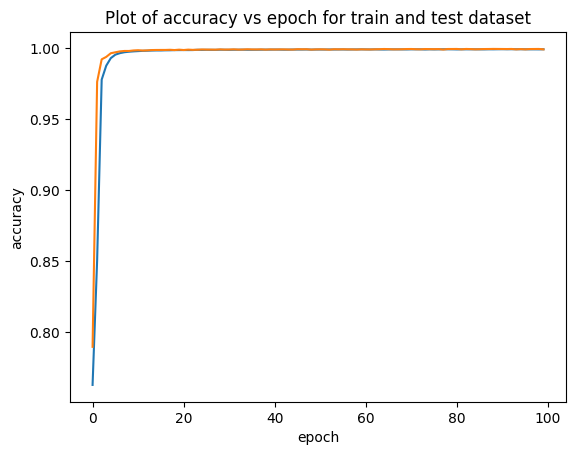

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

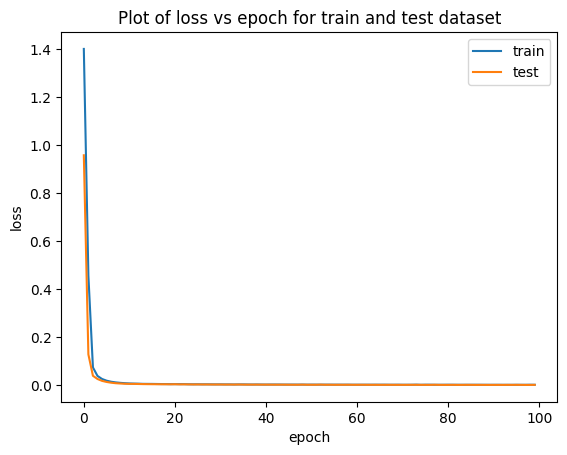

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()